# Работа над цитатами, взятыми с сайта Goodreads

Источник данных: https://www.kaggle.com/faellielupe/goodreads-quotes

## Данные

Список признаков (`Переменная`: Значение):

- `QUOTE`: Текст цитаты
- `AUTHOR`: Автор цитаты
- `TITLE`: Название книги-источника цитаты
- `LIKES`: Количество лайков у цитаты
- `TAGS`: Список тегов для данной цитаты

__quotes.sqlite__ - датасет

In [1]:
import warnings
warnings.filterwarnings('ignore')

import sqlite3
from tqdm.notebook import tqdm
from IPython.display import display
import pickle
from langdetect import detect as detect_language
import ast
import string
from itertools import tee
import textwrap

import numpy as np
from scipy import spatial
from scipy.sparse import lil_matrix
import pandas as pd

import matplotlib.pyplot as plt; plt.rcParams['figure.dpi'] = 100
import seaborn as sns; sns.set()
import plotly.graph_objects as go
import plotly.express as px

from sklearn.manifold import TSNE
from sklearn.feature_extraction.text import CountVectorizer

import nltk
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer

import gensim
from gensim.models import Word2Vec
from gensim.models.ldamodel import LdaModel

## 1. Семантический поиск похожих цитат

Напишем механизм, который позволит находить похожие по содержанию и смыслу цитаты к введённой нами. Будем оценивать текст цитат (подгрузим также авторов статей большей информативности): 

In [2]:
connection = sqlite3.connect('quotes.sqlite')
data = pd.read_sql_query('SELECT QUOTE, AUTHOR FROM QUOTES', connection)
connection.close()

data.head()

,QUOTE,AUTHOR
0,“My life amounts to no more than one drop in a...,David Mitchell
1,“A half-read book is a half-finished love affa...,David Mitchell
2,“Our lives are not our own. We are bound to ot...,David Mitchell
3,"“Travel far enough, you meet yourself.”",David Mitchell
4,"“Books don't offer real escape, but they can s...",David Mitchell


In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 348085 entries, 0 to 348084
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   QUOTE   348085 non-null  object
 1   AUTHOR  348085 non-null  object
dtypes: object(2)
memory usage: 5.3+ MB


При чтении результатов запросов к базам данных `pandas` не преобразовывает пропуски в данных в `np.nan`-объекты, а записывает их как `'None'`-строки, поэтому необходимо проверить их наличие вручную:

In [4]:
print('Количество пропущенных значений для QUOTE:', np.sum(data.QUOTE == 'None'))
print('Количество пропущенных значений для AUTHOR:', np.sum(data.AUTHOR == 'None'))

Количество пропущенных значений для QUOTE: 0
Количество пропущенных значений для AUTHOR: 0


Пропущенных значений нет.

Посмотрим на значения текстов цитат:

In [5]:
print(data.QUOTE.values[:5])

['“My life amounts to no more than one drop in a limitless ocean. Yet what is any ocean, but a multitude of drops?”  \n  ―'
 '“A half-read book is a half-finished love affair.”'
 '“Our lives are not our own. We are bound to others, past and present, and by each crime and every kindness, we birth our future.”'
 '“Travel far enough, you meet yourself.”'
 "“Books don't offer real escape, but they can stop a mind scratching itself raw.”"]


Оценим распределение языка цитат:

In [8]:
def get_lang(quote):
    '''Возвращает индикатор языка для цитаты.'''
    try:
        return detect_language(quote)
    except:
        return 'None'

In [9]:
data['LANGUAGE'] = [get_lang(quote) for quote in tqdm(data.QUOTE)]

In [7]:
data.head()

,QUOTE,AUTHOR,LANGUAGE
0,“My life amounts to no more than one drop in a...,David Mitchell,en
1,“A half-read book is a half-finished love affa...,David Mitchell,en
2,“Our lives are not our own. We are bound to ot...,David Mitchell,en
3,"“Travel far enough, you meet yourself.”",David Mitchell,en
4,"“Books don't offer real escape, but they can s...",David Mitchell,en


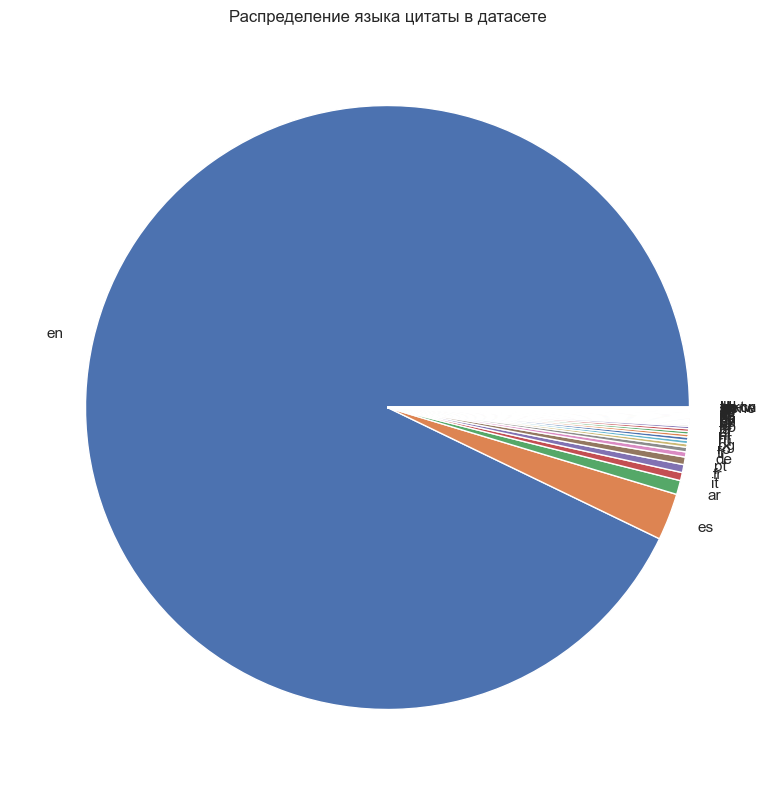

In [5]:
plt.figure(figsize=(10, 10))
data.LANGUAGE.value_counts().plot(kind='pie')
plt.ylabel('')
plt.title('Распределение языка цитаты в датасете')
plt.show()

Цитаты на английском языке преобладают. Сохраним результат:

In [17]:
with open('language.pkl', 'wb') as lang_pkl:
    pickle.dump(data.LANGUAGE.values, lang_pkl)

In [4]:
with open('language.pkl', 'rb') as lang_pkl:
    data['LANGUAGE'] = pickle.load(lang_pkl)

Будем использовать только цитаты на английском.

In [5]:
data = data[data.LANGUAGE == 'en']
data.shape

(323173, 3)

Удалим также очень короткие цитаты (2 слова), их можно считать мусором:

In [6]:
%%time
get_word_count = lambda quote: len(word_tokenize(quote))
data = data[data.QUOTE.apply(get_word_count) > 3]
data.shape

CPU times: user 4min, sys: 329 ms, total: 4min 1s
Wall time: 4min 3s


(322758, 3)

Цитаты представляют из себя обычные необработанные тексты: знаки препинания не удалены (в некоторых местах даже присутствуют лишние), стоп-слова присутствуют, слова не приведены к нормальной форме, не стеммированы и не лемматизированы. Исправим это (предложения будут разделены точками, в будущем точки будут удалены):

In [7]:
# nltk.download('stopwords')
# nltk.download('punkt')

In [21]:
nltk_supported_languages = ['hungarian', 'swedish', 'kazakh', 'norwegian',
                            'finnish', 'arabic', 'indonesian', 'portuguese',
                            'turkish', 'azerbaijani', 'slovene', 'spanish',
                            'danish', 'nepali', 'romanian', 'greek', 'dutch',
                            'tajik', 'german', 'english', 'russian',
                            'french', 'italian']
# список стоп-слов
stop_words = set(stopwords.words(nltk_supported_languages))
# стеммер
porter = PorterStemmer()

In [22]:
def prepare_quote(quote, divide_sentences=True):
    '''Подготовка цитаты: удаление знаков препинания и стоп-слов, стемминг.'''
    prepared_quote = ''
    for sentence in sent_tokenize(quote):
        words = word_tokenize(sentence.lower())
        words_wout_punkt = list(filter(lambda word: word.isalnum(), words))
        words_wout_stopwords = list(filter(lambda word: word not in stop_words, words_wout_punkt))
        stemmed_words = list(map(lambda word: porter.stem(word), words_wout_stopwords))
        if stemmed_words != []:
            prepared_quote += ' '.join(stemmed_words) + ('. ' if divide_sentences else '')
    
    return prepared_quote

In [36]:
%%time
data['PREPARED_QUOTE'] = [prepare_quote(quote) for quote in tqdm(data.QUOTE)]


CPU times: user 10min 7s, sys: 3.92 s, total: 10min 11s
Wall time: 10min 10s


In [37]:
print('Оригинальная цитата:\n', data.QUOTE[0])
print('Обработанная:\n', data.PREPARED_QUOTE[0])

Оригинальная цитата:
 “My life amounts to no more than one drop in a limitless ocean. Yet what is any ocean, but a multitude of drops?”  
  ―
Обработанная:
 life amount drop limitless ocean. yet ocean multitud drop. 


Сохраним результат обработки:

In [38]:
# сохранение в файл
with open('prepared_quotes.pkl', 'wb') as pq_pkl:
    pickle.dump(data.PREPARED_QUOTE.values, pq_pkl)

In [7]:
# подгрузка из файла
with open('prepared_quotes.pkl', 'rb') as pq_pkl:
    data['PREPARED_QUOTE'] = pickle.load(pq_pkl)

Удалим из датасета записи, описывающие цитаты, которые до предобработки состояли исключительно из знаков препинания и стоп-слов:

In [8]:
data = data[data.PREPARED_QUOTE != '']
data.shape

(322544, 4)

Для поиска похожих по смыслу цитат будет использоваться алгоритм создания вложений для слов word2vec. После цитаты будут сравниваться друг с другом по среднему всех векторов слов, из которых они состоят. Натренируем модель word2vec (Skip Gram версия):

In [41]:
# объединим все цитаты в одну строку
joined_quotes = ''.join(data['PREPARED_QUOTE'])
joined_quotes[:300]

'life amount drop limitless ocean. yet ocean multitud drop. book love affair. live. bound other past present crime everi kind birth futur. travel far enough meet. book offer real escap stop mind scratch raw. believ anoth world wait us. better world. wait. peopl pontif suicid selfish. career churchmen'

In [42]:
%%time
# преобразуем строку в список предложений, каждое из которых является списком слов
sentences_as_word_lists = [word_tokenize(sentence.replace('.', '')) 
                           for sentence in tqdm(sent_tokenize(joined_quotes))]
sentences_as_word_lists[:5]



CPU times: user 4min 11s, sys: 2.97 s, total: 4min 14s
Wall time: 4min 18s


[['life', 'amount', 'drop', 'limitless', 'ocean'],
 ['yet', 'ocean', 'multitud', 'drop'],
 ['book', 'love', 'affair'],
 ['live'],
 ['bound',
  'other',
  'past',
  'present',
  'crime',
  'everi',
  'kind',
  'birth',
  'futur']]

In [43]:
%%time
# тренировка модели
model = Word2Vec(sentences_as_word_lists, min_count=1, size=100, window=5, sg=1, workers=4)

CPU times: user 10min 1s, sys: 1.84 s, total: 10min 3s
Wall time: 3min 6s


Проверим работу модели:

In [14]:
print('Похожесть слов "cry" и "shout":', model.similarity(porter.stem('cry'), porter.stem('shout')))
print('Похожесть слов "cry" и "auto" :', model.similarity(porter.stem('cry'), porter.stem('auto')))

Похожесть слов "cry" и "shout": 0.719022
Похожесть слов "cry" и "auto" : 0.3060099


Хорошо, сохраним модель и приступим к механизму нахождения похожих цитат.

In [45]:
# сохранение в файл
model.save('word2vec_model.gs')

In [111]:
# подгрузка из файла
model = Word2Vec.load('word2vec_model.gs')

Посчитаем и добавим в таблицу `data` векторы цитат для удобства:

In [112]:
def get_quote_vector(quote):
    '''Вычисление вектора для цитаты.'''
    words = word_tokenize(quote.replace('.', ''))
    word_vectors = []
    for word in words:
        try:
            word_vectors += [model.wv[word]]
        except KeyError:
            continue
    
    quote_vector = np.mean(word_vectors, axis=0)
    return quote_vector

In [113]:
%%time
data['QUOTE_VECTOR'] = data['PREPARED_QUOTE'].apply(get_quote_vector)

CPU times: user 1min 51s, sys: 541 ms, total: 1min 52s
Wall time: 1min 56s


In [114]:
data.head()

,QUOTE,AUTHOR,LANGUAGE,PREPARED_QUOTE,QUOTE_VECTOR
0,“My life amounts to no more than one drop in a...,David Mitchell,en,life amount drop limitless ocean. yet ocean mu...,"[0.10461172, -0.058469925, 0.21452108, -0.2880..."
1,“A half-read book is a half-finished love affa...,David Mitchell,en,book love affair.,"[0.11077732, -0.22591327, -0.018270377, -0.345..."
2,“Our lives are not our own. We are bound to ot...,David Mitchell,en,live. bound other past present crime everi kin...,"[0.055178106, 0.08037259, 0.015577933, -0.2612..."
3,"“Travel far enough, you meet yourself.”",David Mitchell,en,travel far enough meet.,"[0.044136025, -0.14412153, 0.21425459, -0.2030..."
4,"“Books don't offer real escape, but they can s...",David Mitchell,en,book offer real escap stop mind scratch raw.,"[0.19739327, -0.020483296, -0.087877855, -0.03..."


In [115]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 322544 entries, 0 to 348084
Data columns (total 5 columns):
 #   Column          Non-Null Count   Dtype 
---  ------          --------------   ----- 
 0   QUOTE           322544 non-null  object
 1   AUTHOR          322544 non-null  object
 2   LANGUAGE        322544 non-null  object
 3   PREPARED_QUOTE  322544 non-null  object
 4   QUOTE_VECTOR    322544 non-null  object
dtypes: object(5)
memory usage: 14.8+ MB


Удалим записи, для которых сформировать вектор не удалось:

In [116]:
data.dropna(inplace=True)
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 322544 entries, 0 to 348084
Data columns (total 5 columns):
 #   Column          Non-Null Count   Dtype 
---  ------          --------------   ----- 
 0   QUOTE           322544 non-null  object
 1   AUTHOR          322544 non-null  object
 2   LANGUAGE        322544 non-null  object
 3   PREPARED_QUOTE  322544 non-null  object
 4   QUOTE_VECTOR    322544 non-null  object
dtypes: object(5)
memory usage: 14.8+ MB


Функция, возвращающая наиболее похожие цитаты на переданную в неё:

In [17]:
def cosine_similarity(vector1, vector2):
    '''Похожесть векторов (коэффициент Отиаи).'''
    return 1 - spatial.distance.cosine(vector1, vector2)

In [18]:
def get_most_similar(quote, n_similars=10):
    '''Возвращает топ-n_similars похожих на указанную цитат.'''
    quote_vector = get_quote_vector(prepare_quote(quote))
    similarities = []
    for table_quote_vector in tqdm(data.QUOTE_VECTOR):
        similarities += [cosine_similarity(quote_vector, table_quote_vector)]
    
    ind_x_sim_sorted = sorted(list(enumerate(similarities)), 
                              key=lambda pair: pair[1], 
                              reverse=True)
    most_similar = data.iloc[[ind for ind, _ in ind_x_sim_sorted[:n_similars]]][['QUOTE', 'AUTHOR']]
    most_similar['SIMILARITY'] = [sim for _, sim in ind_x_sim_sorted[:n_similars]]
    return most_similar

Проверим работу на одной из цитат из таблицы, на цитате с индексом 1:

In [23]:
%%time
most_similar_to_quote1 = get_most_similar(data.QUOTE[1])


CPU times: user 44.8 s, sys: 437 ms, total: 45.2 s
Wall time: 45.5 s


In [24]:
most_similar_to_quote1

,QUOTE,AUTHOR,SIMILARITY
1,“A half-read book is a half-finished love affa...,David Mitchell,1.000000
346166,"“I had a love affair with books, with the char...",Marya Hornbacher,0.938753
335123,"“Also, how could anyone who loves books not lo...",Will Schwalbe,0.924277
66793,"“When a long book succeeds, the writer and rea...",Stephen King,0.911038
313009,“Of course I loved books more than people.”,Diane Setterfield,0.908722
269153,"“love had turned into ""love affair"" with a beg...",Graham Greene,0.903610
307508,"“I am deaf, I love to read the ebook and regul...",Charlaine Harris,0.903552
269074,"“Book lovers love books!"" her mother announced...",Chris Van Allsburg,0.903313
287490,“Marriage . . . is not a love affair; it is an...,Joseph Campbell,0.901520
77171,“What could be more lovely than writing a book...,Mark Helprin,0.900421


Выведем результат в более понятном виде:

In [25]:
def print_gms_results(original_quote, most_similar_quotes_df):
    '''Отображает информацию о похожих цитатах.'''
    print(f'Цитаты, наиболее похожие на: {original_quote}\n\n')
    for no, quote_info in enumerate(most_similar_quotes_df.values, 1):
        quote, author, similarity = quote_info
        print(f'{no}. {quote} (c) {author} (похожесть: {similarity})\n')

In [26]:
print_gms_results(data.QUOTE[1], most_similar_to_quote1)

Цитаты, наиболее похожие на: “A half-read book is a half-finished love affair.”


1. “A half-read book is a half-finished love affair.” (c) David Mitchell (похожесть: 1.0)

2. “I had a love affair with books, with the characters and their worlds. Books kept me company” (c) Marya Hornbacher (похожесть: 0.9387528896331787)

3. “Also, how could anyone who loves books not love a book that is itself so in love with books?” (c) Will Schwalbe (похожесть: 0.9242767095565796)

4. “When a long book succeeds, the writer and reader are not just having an affair; they are married.” (c) Stephen King (похожесть: 0.9110384583473206)

5. “Of course I loved books more than people.” (c) Diane Setterfield (похожесть: 0.9087222814559937)

6. “love had turned into "love affair" with a begining and an end.” (c) Graham Greene (похожесть: 0.9036098718643188)

7. “I am deaf, I love to read the ebook and regular books. But I am not picky any kind of books. I love all books are best authors.” (c) Charlaine Harris

Механизм работает! Наиболее похожей цитатой на исходную является, конечно же, она сама. Тема остальных цитат совпадает с темой исходной, которую можно описать как "любовь к книгам".

Теперь проверим на цитате, ввёдённой вручную:

In [27]:
custom_quote = '"Without music, life would be a mistake."'

In [28]:
%%time
most_similar_to_custom_quote = get_most_similar(custom_quote)


CPU times: user 39.8 s, sys: 306 ms, total: 40.1 s
Wall time: 40.2 s


In [29]:
print_gms_results(custom_quote, most_similar_to_custom_quote)

Цитаты, наиболее похожие на: "Without music, life would be a mistake."


1. “Without music, life would be a mistake.”  
  ― (c) Friedrich Nietzsche (похожесть: 0.9684449434280396)

2. “Life seems to go on without effort when I am filled with music.” (c) George Eliot (похожесть: 0.9441436529159546)

3. “Without music, life would be a blank to me.” (c) Jane Austen (похожесть: 0.9414180517196655)

4. “If all music did was bring the past alive, that would be fine. You can hide away in music and let it recapture memories of things that used to be. But music is greedy and it wants more of your heart than that. It demands the future, your future. Music wants the rest of your life. So you can't rest easy. At any moment, a song can come out of nowhere to shake you up, jump-start your emotions, ruin your life.” (c) Rob Sheffield (похожесть: 0.9350348711013794)

5. “IF ALL MUSIC DID WAS bring the past alive, that would be fine. You can hide away in music and let it recapture memories of things th

Как оказалось, эта цитата Ницше присутствует в таблице. И снова хороший результат: в общих чертах большинство цитат о музыке и о "том, без чего жизнь была бы ошибкой".

# 2. Предсказание темы цитаты

Попробуем разделить цитаты на темы по их содержанию. В этом нам помогут теги:

In [30]:
connection = sqlite3.connect('quotes.sqlite')
tags = pd.read_sql_query('SELECT TAGS FROM QUOTES', connection)
connection.close()

tags = tags.iloc[data.index]

tags.head()

,TAGS
0,None
1,"['love', 'reading']"
2,None
3,['travel']
4,"['escape', 'reading']"


In [31]:
tags.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 322544 entries, 0 to 348084
Data columns (total 1 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   TAGS    322544 non-null  object
dtypes: object(1)
memory usage: 4.9+ MB


In [32]:
print('Количество пропущенных значений для TAGS:', np.sum(tags.TAGS == 'None'))

Количество пропущенных значений для TAGS: 228058


Теги в базе данных представлены как списки ключевых слов, однако сохранены в формате строк. Для большинства цитат теги не указаны. Заполним пропущенные значения строкой, которую можно интерпретировать как пустой список, и преобразуем строки в списки:

In [33]:
tags['TAGS'].replace('None', '[]', inplace=True)
tags.TAGS.head()

0                       []
1      ['love', 'reading']
2                       []
3               ['travel']
4    ['escape', 'reading']
Name: TAGS, dtype: object

In [34]:
tags['TAGS'] = tags['TAGS'].apply(ast.literal_eval)
tags['TAGS'].head()

0                   []
1      [love, reading]
2                   []
3             [travel]
4    [escape, reading]
Name: TAGS, dtype: object

Теперь данные записаны, как нужно:

In [35]:
tags['TAGS'][1], type(tags['TAGS'][1])

(['love', 'reading'], list)

In [36]:
all_tags = np.hstack(tags['TAGS'])
unique_tags, counts = np.unique(all_tags, return_counts=True)
print('Топ-15 наиболее часто используемых тегов:')
top_tags = pd.DataFrame({'Тег': unique_tags, 'Количество использований': counts}).sort_values(by='Количество использований', 
                                                                                              ascending=False).head(15)
top_tags

Топ-15 наиболее часто используемых тегов:


,Тег,Количество использований
14791,love,4357
14111,life,3077
10829,humor,2860
23485,romance,1184
11663,inspirational,1172
32702,writing,1091
22740,relationship-quotes,1044
30146,truth,1034
22774,religion,1021
22099,quotes-by-susan-c-young,824


По тегам можно примерно оценить наиболее популярные темы цитат. Здесь наиболее популярной оказалась `love`.

Посмотрим, можно ли кластеризовать данные с помощью полученных ранее word2vec векторов. Сократим количество признаков в матрице векторов цитат с помощью t-SNE-преобразования и посмотрим, насколько хорошо темы цитат отделимы друг от друга при таком представлении:

In [118]:
# возьмём случайные 30000 цитат для экономии ресурсов компьютера и времени
sample = data.sample(30000, random_state=42)

In [119]:
%%time
tsne = TSNE(n_components=2, init='pca', random_state=42, n_jobs=-1, n_iter=250)
quotes_2d_tsne = tsne.fit_transform(list(sample.QUOTE_VECTOR))

CPU times: user 16min 43s, sys: 7.96 s, total: 16min 51s
Wall time: 4min 35s


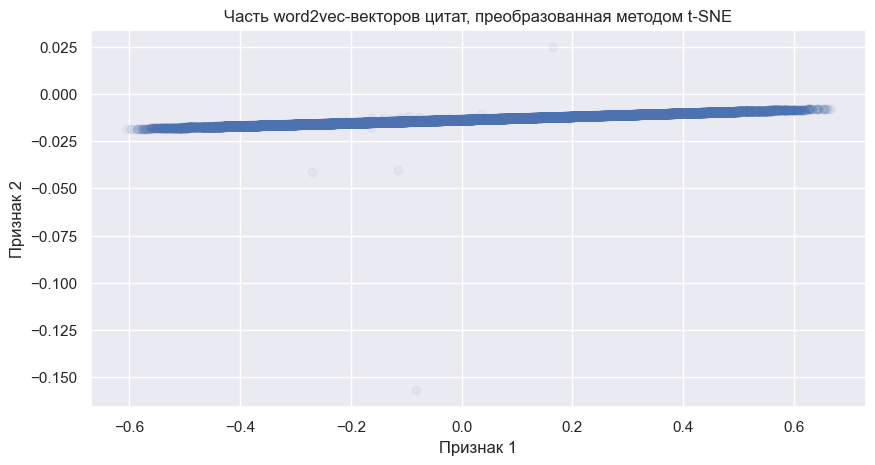

In [120]:
plt.figure(figsize = (10, 5))
plt.scatter(quotes_2d_tsne[:, 0], quotes_2d_tsne[:, 1], alpha=0.05)
plt.xlabel('Признак 1')
plt.ylabel('Признак 2')
plt.title('Часть word2vec-векторов цитат, преобразованная методом t-SNE')
plt.show()

Похоже, что не очень хорошо. Если посмотреть, какие цитаты описаны каждой конкретной точкой (plolty-график, что расположен ниже, такой же, но при наведении курсора на отдельный элемент можно увидеть цитату, которую он описывает), можно сделать вывод, что похожие по смыслу цитаты действительно "расположены" близко друг к другу, однако для кластеризации такое представление скорее всего не подходит:

In [103]:
# Делает однострочный текст многострочным для удобства.
wrap_and_add_brs = lambda text: '<br>'.join(textwrap.wrap(text, width=70))

In [123]:
fig = px.scatter(x = quotes_2d_tsne[:, 0], y = quotes_2d_tsne[:, 1],
                 hover_data=[data.loc[sample.index].QUOTE.apply(wrap_and_add_brs)])


fig.update_layout(
    title = "Часть word2vec-векторов цитат, преобразованная методом t-SNE", 
    xaxis_title="Признак 1",
    yaxis_title="Признак 2")

None
# fig.show()

Поэтому воспользуемся LDA-моделью (методом латентного размещения Дирихле). Будем использовать мешок слов с количествами вхождений слов и их биграм:

In [95]:
# снова, возьмём случайные 100000 цитат для экономии ресурсов компьютера и времени
data_for_lda = data.sample(100000, random_state=42)

Удалим короткие цитаты (меньше 20-ти слов), так как LDA-модель, как правило, показывает плохой результат при обучении на коротких текстах:

In [96]:
get_word_count = lambda quote: len(word_tokenize(quote))
data_for_lda = data_for_lda[data_for_lda.QUOTE.apply(get_word_count) > 20]
data_for_lda.shape

(81322, 4)

In [97]:
count_vect = CountVectorizer(ngram_range=(1, 2))

In [98]:
%%time
prepared_fit_quotes = data_for_lda.PREPARED_QUOTE
quote_vectorized = count_vect.fit_transform(prepared_fit_quotes)
corpus = gensim.matutils.Sparse2Corpus(quote_vectorized, documents_columns=False)
id_map = {v: k for k, v in count_vect.vocabulary_.items()}

CPU times: user 17.4 s, sys: 515 ms, total: 17.9 s
Wall time: 18.2 s


Тренировка модели (число тем равно 30):

In [46]:
%%time
ldamodel = LdaModel(corpus=corpus, id2word=id_map, num_topics=30, 
                    passes=30, update_every=10, eval_every=50)

CPU times: user 39min 56s, sys: 1min 52s, total: 41min 48s
Wall time: 32min 4s


In [47]:
top15_words = ldamodel.print_topics(num_topics=30, num_words=15)
print('Описание тем (номер темы и наиболее "важные" для темы слова):\n')
for n_topic, top_words in top15_words:
    print(f'Тема {n_topic}: {top_words}')
    print()

Описание тем (номер темы и наиболее "важные" для темы слова):

Тема 0: 0.002*"curran" + 0.002*"notic" + 0.001*"lamb" + 0.001*"trollop" + 0.001*"bran" + 0.001*"tyler" + 0.001*"get peopl" + 0.001*"velvet" + 0.001*"would tell" + 0.001*"val" + 0.001*"made look" + 0.001*"hand shoulder" + 0.001*"surpris said" + 0.001*"next five" + 0.001*"contemptu"

Тема 1: 0.001*"receptor" + 0.001*"rogu" + 0.001*"percentag" + 0.001*"long hour" + 0.001*"first breath" + 0.001*"data bank" + 0.001*"better sens" + 0.001*"true would" + 0.001*"psychedel" + 0.000*"doubli" + 0.000*"drudgeri" + 0.000*"sens humour" + 0.000*"live moment" + 0.000*"rio" + 0.000*"radic chang"

Тема 2: 0.002*"enslav" + 0.001*"lotti" + 0.001*"marriag" + 0.001*"fairi tale" + 0.001*"indistinguish" + 0.001*"ever find" + 0.001*"doughnut" + 0.001*"same" + 0.001*"eat disord" + 0.001*"sad thing" + 0.001*"predic" + 0.001*"look make" + 0.001*"ream" + 0.001*"marriag marriag" + 0.001*"prove us"

Тема 3: 0.001*"long breath" + 0.001*"market research" + 

Похоже, что явно выделить темы, ориентируясь по наборам терминов, не получится.

Попробуем конвертировать данные в формат таблицы, где строки описывают цитаты, а столбцы - распределения тем в цитатах, и сгенерировать на её основе синтетические признаки методом t-SNE:

In [99]:
%%time
docs_x_topics = lil_matrix((81322, 30))
topics_ns = []
for doc_ind, doc in enumerate(corpus):
    doc_topics = ldamodel.get_document_topics(doc)
    topics_ns += [max(doc_topics, key=lambda pair: pair[1])[0]]
    for n_topic, prob in doc_topics:
        docs_x_topics[doc_ind, n_topic] = prob

docs_x_topics[:3].todense()

CPU times: user 1min 25s, sys: 4.08 s, total: 1min 29s
Wall time: 1min


matrix([[0.        , 0.        , 0.        , 0.        , 0.        ,
         0.        , 0.        , 0.        , 0.        , 0.        ,
         0.        , 0.        , 0.        , 0.60392725, 0.        ,
         0.        , 0.        , 0.        , 0.        , 0.        ,
         0.        , 0.        , 0.34910011, 0.        , 0.        ,
         0.        , 0.        , 0.        , 0.        , 0.        ],
        [0.        , 0.        , 0.        , 0.        , 0.        ,
         0.        , 0.        , 0.        , 0.        , 0.        ,
         0.        , 0.        , 0.        , 0.90910143, 0.        ,
         0.        , 0.        , 0.        , 0.        , 0.        ,
         0.        , 0.        , 0.        , 0.        , 0.        ,
         0.        , 0.        , 0.        , 0.        , 0.        ],
        [0.        , 0.        , 0.        , 0.        , 0.        ,
         0.        , 0.        , 0.        , 0.        , 0.        ,
         0.        , 0.        ,

In [100]:
%%time
tsne = TSNE(n_components=2, random_state=42, n_jobs=-1, n_iter=250)
dt_2d_tsne = tsne.fit_transform(docs_x_topics)

CPU times: user 30min 55s, sys: 3min 14s, total: 34min 9s
Wall time: 12min 41s


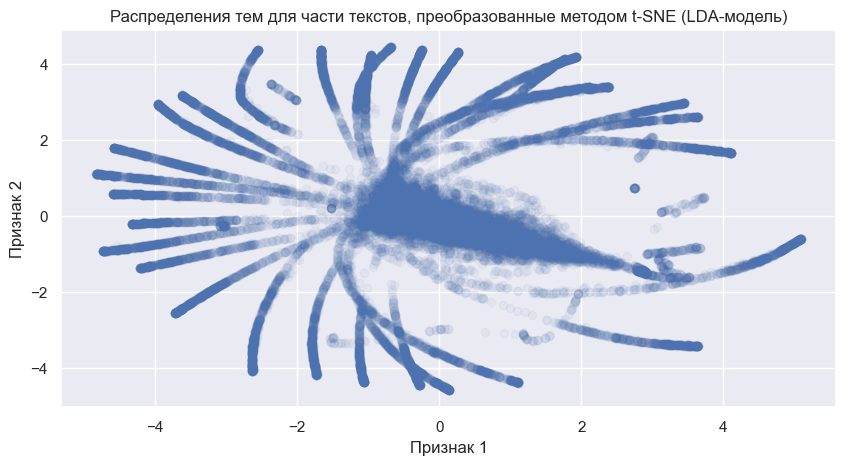

In [101]:
plt.figure(figsize = (10, 5))
plt.scatter(dt_2d_tsne[:30000, 0], dt_2d_tsne[:30000, 1], alpha=0.05)
plt.xlabel('Признак 1')
plt.ylabel('Признак 2')
plt.title('Распределения тем для части текстов, преобразованные методом t-SNE (LDA-модель)')
plt.show()

Видно, что объекты уже проще разделить. Plotly-график с отображением содержания цитат при наведении курсора:

In [108]:
fig = px.scatter(x = dt_2d_tsne[:30000, 0], y = dt_2d_tsne[:30000, 1], 
                 color=list(map(lambda el: f'Тема {el}', topics_ns[:30000])), 
                 hover_data=[data_for_lda.QUOTE[:30000].apply(wrap_and_add_brs)])


fig.update_layout(
    title = "Распределения тем для части текстов, преобразованные методом t-SNE (LDA-модель)", 
    xaxis_title="Признак 1",
    yaxis_title="Признак 2")
fig.write_image(f'Distributions of topics (t-SNE, LDA) rus.png', width=1200, height=800)
# fig.show()

Однако, даже при таком представлении нельзя сказать, что кластеризация проходит хорошо (возможно, здесь поможет увеличение количества итераций при обучении модели, но это займёт очень много времени).

Сохраним модель:

In [52]:
# сохранение в файл
ldamodel.save('lda_model.gs')

In [94]:
# подгрузка из файла
ldamodel = LdaModel.load('lda_model.gs')

Попробуем другой тип модели. Прочитать о нём можно здесь: https://towardsdatascience.com/short-text-topic-modeling-70e50a57c883

В данном случае каждая цитата будет рассматриваться как текст, принадлежащий только одной теме, а не к нескольким сразу. Такой приём лучше подходит для коротких текстов.

In [35]:
!git clone https://github.com/rwalk/gsdmm.git

Cloning into 'gsdmm'...
remote: Enumerating objects: 50, done.
remote: Total 50 (delta 0), reused 0 (delta 0), pack-reused 50
Unpacking objects: 100% (50/50), 11.20 KiB | 272.00 KiB/s, done.


In [9]:
from gsdmm.gsdmm.mgp import MovieGroupProcess

Возьмём те же данные, но на этот раз не будем удалять короткие цитаты:

In [75]:
data_for_mgp = data.sample(100000, random_state=42)

In [76]:
get_first_2_sents = lambda quote: ' '.join(sent_tokenize(quote)[:3])
data_for_mgp['PREPARED_QUOTE'] = data_for_mgp.PREPARED_QUOTE.apply(get_first_2_sents)

Подготовим цитаты:

In [77]:
docs = data_for_mgp.PREPARED_QUOTE.str.replace('.', '').str.split().tolist()
docs[0]

['taught',
 'act',
 'like',
 'someth',
 'work',
 'told',
 'pretend',
 'complet',
 'control',
 'peopl']

In [78]:
def make_bigrams(list_of_words):
    '''Генерация биграм на основе текста.'''
    a, b = tee(list_of_words)
    next(b, None)
    return [' '.join(pair) for pair in zip(a, b)]

make_bigrams(docs[0])

['taught act',
 'act like',
 'like someth',
 'someth work',
 'work told',
 'told pretend',
 'pretend complet',
 'complet control',
 'control peopl']

In [79]:
docs = [doc + make_bigrams(doc) for doc in docs]

In [80]:
vocab = set(word for doc in docs for word in doc)
n_terms = len(vocab)

Тренировка модели (30 тем):

In [81]:
%%time
mgpmodel = MovieGroupProcess(K=30, alpha=0.1, beta=0.07, n_iters=10)
mgp_results = np.array(mgpmodel.fit(docs, n_terms))

In stage 0: transferred 86795 clusters with 30 clusters populated
In stage 1: transferred 52667 clusters with 30 clusters populated
In stage 2: transferred 42650 clusters with 30 clusters populated
In stage 3: transferred 32963 clusters with 30 clusters populated
In stage 4: transferred 25219 clusters with 30 clusters populated
In stage 5: transferred 20613 clusters with 30 clusters populated
In stage 6: transferred 18426 clusters with 30 clusters populated
In stage 7: transferred 16612 clusters with 30 clusters populated
In stage 8: transferred 15804 clusters with 30 clusters populated
In stage 9: transferred 15079 clusters with 30 clusters populated
CPU times: user 52min 45s, sys: 1.32 s, total: 52min 46s
Wall time: 52min 52s


In [82]:
doc_count = np.array(mgpmodel.cluster_doc_count)
print('Количество документов на каждую тему:')
display(pd.DataFrame(list(enumerate(doc_count)), columns=['Тема', 'Количество документов']))

top_index = doc_count.argsort()[::-1]
print('Топ тем по количеству документов:', top_index)

Количество документов на каждую тему:


,Тема,Количество документов
0,0,3834
1,1,7098
2,2,4304
3,3,2381
4,4,69
5,5,36
6,6,3658
7,7,31
8,8,7777
9,9,5950


Топ тем по количеству документов: [24 25 13 29  8  1  9 17 21  2 28  0  6 20  3 22 23 19  4 16 11 10 26 14
 12 27 15 18  5  7]


In [83]:
def top_words(distributions, indexes, n_words):
    '''Выводит описание тем.'''
    for index in indexes:
        top_words = sorted(list(distributions[index].items()), 
                           key=lambda dist: dist[1], 
                           reverse=True)[:n_words]
        print(f'Тема {index}: {top_words}\n')

In [84]:
print('Описание тем (номер темы и наиболее "важные" для темы слова):\n')
top_words(mgpmodel.cluster_word_distribution, top_index, 15)

Описание тем (номер темы и наиболее "важные" для темы слова):

Тема 24: [('peopl', 3077), ('thing', 2888), ('like', 2211), ('make', 1943), ('get', 1721), ('think', 1702), ('life', 1613), ('know', 1594), ('time', 1386), ('love', 1352), ('way', 1343), ('feel', 1303), ('go', 1297), ('say', 1229), ('good', 1195)]

Тема 25: [('like', 2091), ('would', 1771), ('time', 1716), ('could', 1666), ('go', 1525), ('look', 1404), ('love', 1326), ('life', 1236), ('never', 1191), ('know', 1149), ('see', 1146), ('day', 1075), ('said', 1001), ('thing', 959), ('world', 941)]

Тема 13: [('know', 2281), ('love', 1820), ('life', 1383), ('thing', 1378), ('never', 1276), ('would', 1235), ('said', 1193), ('think', 1158), ('live', 1102), ('peopl', 998), ('say', 960), ('us', 929), ('someth', 854), ('could', 838), ('alway', 731)]

Тема 29: [('like', 2186), ('would', 2151), ('time', 1764), ('peopl', 1600), ('could', 1431), ('life', 1412), ('world', 1362), ('thing', 1265), ('even', 1212), ('make', 1193), ('us', 1170)

Так как здесь придумать визуальное представление для результатов трудно, оценим первые 10 цитат для нескольких "топовых" тем: 

In [87]:
def print_10quotes(topic_n):
    for quote in data_for_mgp[mgp_results == topic_n].QUOTE[:10]:
        print(quote)
        print()

In [88]:
print_10quotes(24)

“I taught him that if you act like you can do something, then it will work. I told him, ‘Pretend to be completely in control and people will”  
  ―

“Edison’s efforts then took a turn for the grisly.”

“The crime rates would go right down, I think, if Americans stopped saying: 'Have a nice day,' to one another. At least it would stop me from contemplating violence; when people in shops & so on order me to have a nice day in this authoritarian way, I want to kill, kill, kill. When I mutter 'sod off' under my breath, they think it is a Russian Orthodox benediction.”

“I made the mistake of looking down when I got ready to wash his legs. The water in the lagoon was clear enough to see that he had a hard-on sticking up in this shorts. "TJ!"
"Sorry." He looked at me sheepishly. "I cant hide this one."
I suddenly didn't know where to look. It wasn't his fault though; I had forgotten what would happen if you rubbed a seventeen-year-old all over with your hands.
Or any man, actually.”

“There 

In [89]:
print_10quotes(25)

“This is a street where the weaker souls crawl into bed as soon as the sun sets and lie awake listening to the rats.”  
  ―

“I had never seen a prison, nor had I even imagined one, but there is a racial memory in man that instinctively knows of these things. The architecture of misery has an unmistakable look and feel about it.”

“There was a time I didn't know your name
Why should I worry, cry in vain
but now she's gone, and I don't worry
cause I'm sittin' on top of the world.”

“I am worried about being in love, because it involves asking so much. I am worried that my life will never fit into his. That I will never know him. That he will never know me. That we get to hear the stories, but never get to hear the full truth.”

“But castles in the air were founded on such hopes.”

“What darkness to you is light to me”

“How are you going to make it move? It doesn't have a – " 
"Be very quiet," advised the duke, "for it goes without saying."
And, sure enough, as soon as they were all qui

In [90]:
print_10quotes(13)

“the rotten tree-trunk, until the very moment when the storm-blast breaks it in two, has all the appearance of might it ever had.”

“At a certain point he learned the smarter play was to avoid the things that brought you low.”

“It is rare for people to be asked the question which puts them squarely in front of themselves”

“And in the end, of course, a true war story is never about war. It’s about sunlight. It’s about the special way that dawn spreads out on a river when you know you must cross the river and march into the mountains and do things you are afraid to do. It’s about love and memory. It’s about sorrow. It’s about sisters who never write back and people who never listen.”

“People talk about evidence as if it could really be weighed in scales by a blind Justice.”

“That was what a young woman was for. You seduced a young woman in order to be able to finish your talks with her. You could not do that without living with her. You could not live with her without seducing her; b

In [91]:
print_10quotes(20)

“Roses are red. Blood is too…”

“So for a while, they sat peacefully in the swamp, listening to Mrs. Starch hum while the little panther slurped happily and the emerald leaves overhead shimmered and shook in the sunlight.”  
  ―

“A woman I know gave me a build-it-yourself bird-feeder kit for Christmas, so I built it, and hung it from the eve of my roof high enough to keep the birds save from my cat. But the birds scratch the seed out of the feeder, then fly down to the deck and eat the seed. They know there's a cat, but still they go down to pick at the seed. When you think about it, people are often like this, too.”

“Oak, granite,
Lilies by the road,
Remember me?
I remember you.
Clouds brushing
Clover hills,
Remember me?
Sister, child,
Grown tall,
Remember me?
I remember you.”

“It was raining. Gigantic ferns leaned over us. The forest drifted down a hill. I could hear a creek rushing down among the rocks. And you, you ridiculous people, you expect me to help you.”  
  ―

“crenellat

In [92]:
print_10quotes(3)

“There was only one catch and that was Catch-22, which specified that a concern for one’s own safety in the face of dangers that were real and immediate was the process of a rational mind.”

“Several days after the original accident in June 1991, William was recovering sufficiently well to allow the Princess to fulfill a commitment to visit Marlow Community Hospital. As she was leaving, an old man in the crowd collapsed with an attack of angina. Diana rushed over to help rather than leaving it to others. When the Prince saw the media coverage of her sympathetic actions, he accused Diana of behaving like a martyr. His sour response typified the yawning gulf between them and gave substance to Diana’s observations on the media interest in their 10th wedding anniversary the following month. She asked in her matter-of-fact way: “What is there to celebrate?”

“Oh, by the way, Phury's here again, and he brought that Chosen with him. Figured you'd want to know in case you see a random female g

Похоже, что ни ни для одного из просмотренных наборов предложений нельзя выявить по-настоящему общую для всех тему. Видимо, цитаты действительно очень непросто кластеризировать...

Сохраним модель и её результаты (просто чтобы не тренировать потом заново):

In [125]:
# сохранение в файл
with open('mgp_model.pkl', 'wb') as mgp_model_pkl:
    pickle.dump(mgpmodel, mgp_model_pkl)

In [126]:
# подгрузка из файла
with open('mgp_model.pkl', 'rb') as mgp_model_pkl:
    mgpmodel = pickle.load(mgp_model_pkl)

In [127]:
# сохранение в файл
with open('mgp_results.pkl', 'wb') as mgp_results_pkl:
    pickle.dump(mgp_results, mgp_results_pkl)

In [128]:
# подгрузка из файла
with open('mgp_results.pkl', 'rb') as mgp_results_pkl:
    mgp_results = pickle.load(mgp_results_pkl)

Итоговое содержимое папки с работой:

In [130]:
!ls

'Distributions of topics (t-SNE, LDA) rus.png'
'Goodreads quotes.ipynb'
 gsdmm
 language.pkl
 lda_model.gs
 lda_model.gs.expElogbeta.npy
 lda_model.gs.id2word
 lda_model.gs.state
 lda_model.gs.state.sstats.npy
 mgp_model.pkl
 mgp_results.pkl
 prepared_quotes.pkl
 quotes.sqlite
 README.md
 word2vec_model.gs
 word2vec_model.gs.trainables.syn1neg.npy
 word2vec_model.gs.wv.vectors.npy
